# Auto Encoder

オートエンコーダ

入力したものをそのまま出力するニューラルネットワーク．  
**encoder**と**decoder**の2つの部分からなる．

- encoder：入力を低次元のベクトルに変換する
- decoder：encoderの出力を元の次元に戻す

入力を一度低次元の空間に埋め込み，そこから復元するイメージ．学習が進むと，encoderの出力は入力データの特徴を捉えた**潜在変数**として扱うことが出来る．

<br>

活用例

- ノイズ削除
- 次元削減
- 異常検知

<br>

ここではノーマルなオートエンコーダを実装してみる．  
MNISTを使って、何ができるか試してみよう．

In [1]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')


---

## 学習

モデルを作ってみよう

In [2]:
mnist = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
dataloader = DataLoader(mnist, batch_size=64, shuffle=True)

def draw(model, n_images=10, width=800):
    """画像描画用関数"""
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(dataloader))
        x = x.view(x.size(0), -1)[:n_images].to(device)
        y = model(x)
    img = torch.cat([x, y], dim=0).view(-1, 1, 28, 28).cpu()
    img = transforms.Resize((width // n_images))(img)
    img = torchvision.utils.make_grid(img, nrow=n_images)
    img = transforms.functional.to_pil_image(img)
    display(img)

### モデル用意

encoderとdecoderを実装し，それらを組み合わせる

`z_dim`: 潜在変数の次元数

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, z_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

学習させてみよう．MSEを損失関数として使い，入力と出力の差を取る．これが小さくなるように学習させる．

In [4]:
critetion = nn.MSELoss()

def train(model, n_epochs, optimizer):
    model.train()
    for epoch in range(n_epochs):
        for x, _ in dataloader:
            optimizer.zero_grad()
            x = x.view(x.size(0), -1).to(device)
            y = model(x)
            loss = critetion(y, x)
            loss.backward()
            optimizer.step()
        print(f'{epoch+1}epoch, loss:{loss.item()}')

In [5]:
z_dim = 10
ae = AutoEncoder(z_dim).to(device)
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

5エポック学習

In [6]:
n_epochs = 5
train(ae, n_epochs, optimizer)

1epoch, loss:0.026190361008048058
2epoch, loss:0.01653441973030567
3epoch, loss:0.015190919861197472
4epoch, loss:0.015891436487436295
5epoch, loss:0.019127219915390015


結果を見てみる

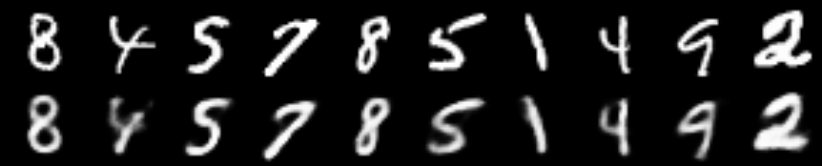

In [7]:
draw(ae)

上が入力，下が出力．  
入力をしっかりと復元できていることが分かる．

では，活用例を見てみる


---

## 次元削減

encoderは入力を低次元に圧縮しているので，そこを使えば次元削減ができる．

潜在変数の次元数を2とし，encoderを使って二次元の潜在変数をプロットする．

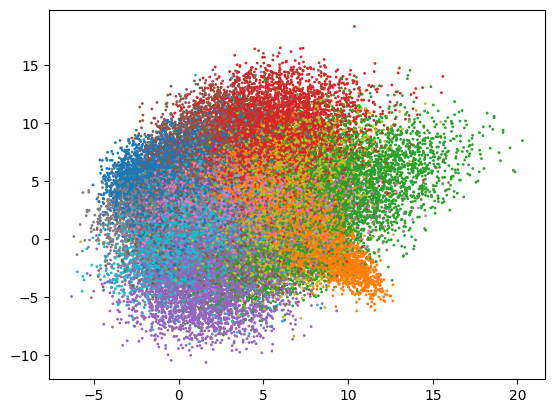

In [8]:
images = []
labels = []
ae.eval()
with torch.no_grad():
    for x, label in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        images.append(z.cpu())
        labels.append(label)
images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
plt.scatter(images[:, 0], images[:, 1], c=labels, s=1, cmap='tab10');

数字ごとに特徴が表れているのが分かる

### 学習しなかった場合

学習をしていないencoderで次元削減をするとどうなるのか

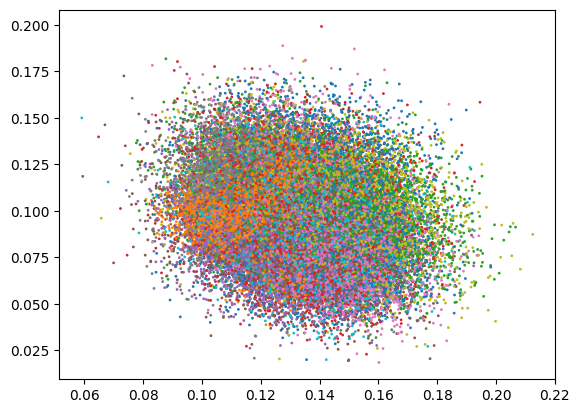

In [9]:
ae = AutoEncoder(z_dim).to(device)

images = []
labels = []
ae.eval()
with torch.no_grad():
    for x, label in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        images.append(z.cpu())
        labels.append(label)
images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
plt.scatter(images[:, 0], images[:, 1], c=labels, s=1, cmap='tab10');

このように，ごちゃごちゃになる
ただよく見ると，ほんの少し色の偏りが見られると思う．全てのデータに対して同じ処理で2次元に圧縮しているため，元のデータ（入力画像）が似ていれば，2次元のベクトルも似たものになる．  

ここで，元の画像と，その白黒を反転させた画像をencoderで圧縮し，描画してみよう．

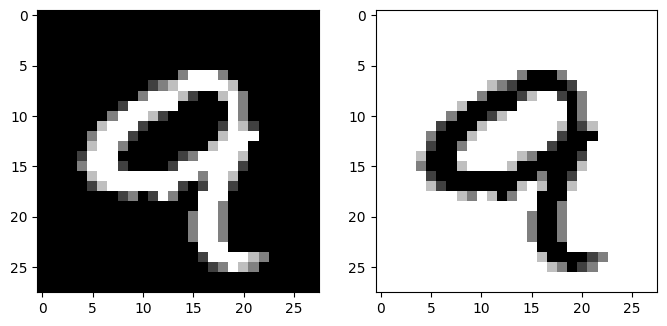

In [10]:
x = next(iter(dataloader))[0][0, 0]
reverse_x = 1 - x
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(x, cmap='gray')
axes[1].imshow(reverse_x, cmap='gray');

左が元の画像，右が反転させた画像

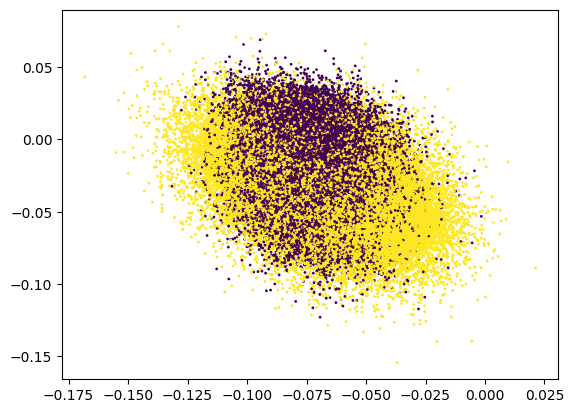

In [11]:
ae = AutoEncoder(z_dim).to(device)

images = []
labels = []
ae.eval()
with torch.no_grad():
    for x, _ in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        images.append(z.cpu())
        labels.append(torch.zeros(len(z)))

        reverse_x = 1 - x
        z = ae.encoder(reverse_x)
        images.append(z.cpu())
        labels.append(torch.ones(len(z)))

images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
plt.scatter(images[:, 0], images[:, 1], c=labels, s=1);

未学習でも違いが顕著に表れた．

元の画像は黒主体の画像で，反転すると白主体の画像になる．この2種類のデータ（ベクトル）はベクトル空間$\mathbb{R}^{784}$上である程度距離が離れているため，適当な関数（未学習のencoder）で2次元空間$\mathbb{R}^2$上に写像しても距離が離れる．  
一方で，その2種類の中での**数字の違いによる$\mathbb{R}^{784}$上の距離**は先程の2種類に比べて小さいものとなるため，適当な関数で2次元空間$\mathbb{R}^2$に写像してもあまり違いが表れない．  
違いが表れるようにするには，$\mathbb{R}^{784}$の中で**対象の画像が存在する領域に着目**する必要がある．オートエンコーダを学習させることで，encoderはその領域と$\mathbb{R}^2$の対応を正確に捉えられるようになる．


---

## ノイズ削除

AEを使って低次元に圧縮することで，重要な要素を残しつつ情報量を減らせるため，ノイズ削除に使える．  
上の例にもある通り、下の方がぼやけているのが分かる。

潜在変数の次元数を減らすと、もっとぼやける

1epoch, loss:0.04817333444952965
2epoch, loss:0.04371737688779831
3epoch, loss:0.04107195883989334
4epoch, loss:0.04117182269692421
5epoch, loss:0.03743484616279602


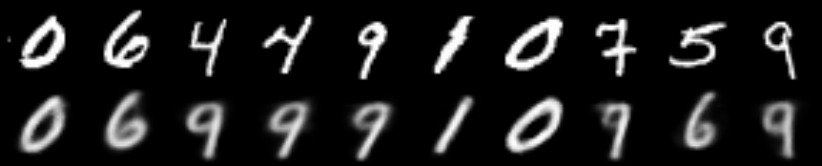

In [12]:
# 2に減らす
z_dim = 2

ae = AutoEncoder(z_dim).to(device)
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
n_epochs = 5
train(ae, n_epochs, optimizer)
draw(ae)


---

## 異常検知

入力と似た出力が行えるのは，入力が学習に使用したデータと同じ特徴を持っているときだけ．この性質を使って異常検知を行う．  
具体的な流れは以下

1. 正常なデータで学習させる
2. モデルに何らかのデータを入力する
3. モデルの出力と入力の誤差を計算する
4. 誤差が閾値を超えていたら異常と判定する

<br>

試しに，数字の0だけでモデルを学習させてみよう

In [13]:
z_dim = 10
ae = AutoEncoder(z_dim).to(device)
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
n_epochs = 5

ae.train()
for epoch in range(n_epochs):
    for x, labels in dataloader:
        if 0 not in labels:
            continue
        x = x[labels == 0] # 0だけ使用
        optimizer.zero_grad()
        x = x.view(x.size(0), -1).to(device)
        y = ae(x)
        loss = critetion(y, x)
        loss.backward()
        optimizer.step()
    print(f'{epoch+1}epoch, loss:{loss.item()}')

1epoch, loss:0.02847340889275074
2epoch, loss:0.020094219595193863
3epoch, loss:0.017280636355280876
4epoch, loss:0.013796922750771046
5epoch, loss:0.016074443235993385


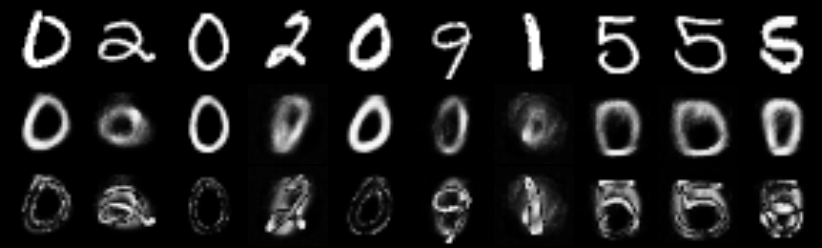

In [14]:
n_images = 10
width = 800

ae.eval()
with torch.no_grad():
    for x, labels in dataloader:
        if 0 not in labels[:n_images]:
            continue
        x = x[:n_images]
        x = x.view(x.size(0), -1).to(device)
        y = ae(x)
        break

x = x.view(n_images, 1, 28, 28).cpu()
y = y.view(n_images, 1, 28, 28).cpu()
diff = (x - y).abs()
diff = (diff - diff.min()) / (diff.max() - diff.min())
f = width // n_images
x = transforms.Resize((f))(x)
y = transforms.Resize((f))(y)
diff = transforms.Resize((f))(diff)
grid = torchvision.utils.make_grid(torch.cat([x, y, diff], dim=0), nrow=n_images)
img = transforms.functional.to_pil_image(grid)
display(img)

- 1段目：入力
- 2段目：出力
- 3段目：入力と出力の差

0以外の数値では上手く復元できていないのが分かる．というかどれも0っぽくなってしまっているね．これを見ると，入力と出力の差が大きいデータを異常と判定することができそう．

差の和を見てみる

In [15]:
print('label: diff')
for diff, label in zip(diff, labels):
    print(f'{label.item():>5}: {diff.sum().item():.3f} ')

label: diff
    0: 398.853 
    2: 795.636 
    0: 171.218 
    2: 843.935 
    0: 223.151 
    9: 603.512 
    1: 820.634 
    5: 799.315 
    5: 896.940 
    5: 770.268 


0が他と比べて小さいのが分かる


---

## データ生成

decoderを使ってデータを生成する．潜在変数が何らかの分布に従っているという仮定が必要．  
具体的な手順は以下．

- AEを学習させる
- 潜在変数が従っている分布を求める
- その分布から潜在変数をサンプリングする
- decoderに潜在変数を入力してデータを生成する

<br>

とりあえず学習させる

1epoch, loss:0.04201032593846321
2epoch, loss:0.04797904193401337
3epoch, loss:0.03811151534318924
4epoch, loss:0.03781180828809738
5epoch, loss:0.037784356623888016


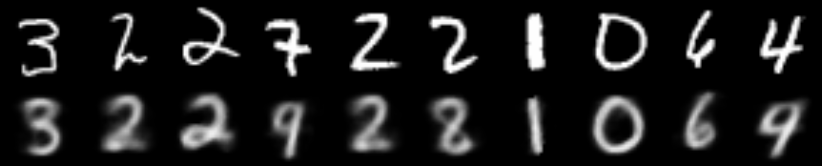

In [16]:
z_dim = 2

ae = AutoEncoder(z_dim).to(device)
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
n_epochs = 5
train(ae, n_epochs, optimizer)
draw(ae)

### 潜在変数の分布を求める

まずは観察

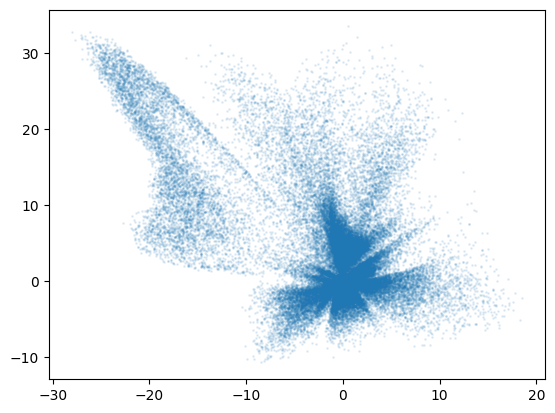

In [17]:
latents = []
ae.eval()
with torch.no_grad():
    for x, label in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        latents.append(z.cpu())
latents = torch.cat(latents, dim=0)
plt.scatter(latents[:, 0], latents[:, 1], s=1, alpha=0.1);

複雑な形だが、適当に混合ガウス分布で近似してみる

estimated n_classes: 10


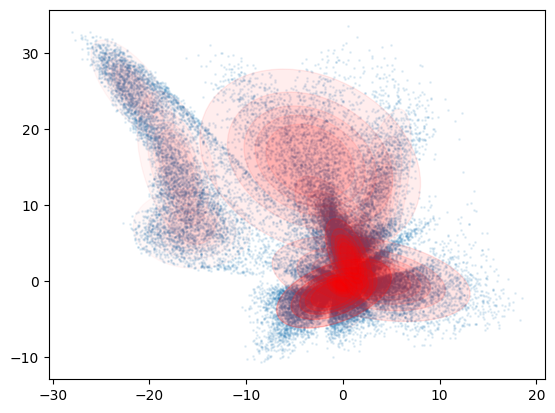

In [18]:
from sklearn.mixture import BayesianGaussianMixture
from matplotlib.patches import Ellipse

# 推定
vbgmm = BayesianGaussianMixture(n_components=10)
vbgmm.fit(latents)

# パラメータ取得
weights = vbgmm.weights_
means = torch.tensor(vbgmm.means_)
covs = torch.tensor(vbgmm.covariances_)
n_classes = len(weights)
print('estimated n_classes:', n_classes)

# 可視化
plt.scatter(latents[:, 0], latents[:, 1], s=1, alpha=0.1)
ax = plt.gca()
for pos, cov, w in zip(means, covs, weights):
    U, s, Vt = np.linalg.svd(cov)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)
    for size in [0.8, 1.0, 1.2, 1.5, 2.0]:
        elipse = Ellipse(pos, size*width, size*height, angle, alpha=w, color='red')
        ax.add_patch(elipse)

この赤い範囲が推定された分布。ここから潜在変数をサンプリングする。

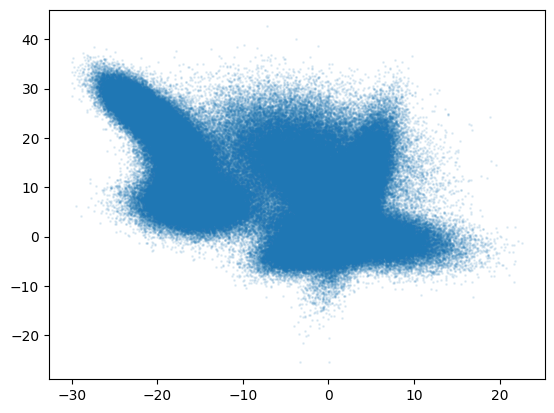

In [19]:
import pyro
import pyro.distributions as dist

n_samples = len(latents)
norms = [dist.MultivariateNormal(mean, cov) for mean, cov in zip(means, covs)]
z = []
for i, n in enumerate((weights * n_samples).astype(int)):
    with pyro.plate('', n_samples):
        z.append(pyro.sample('', norms[i]))
z = torch.cat(z, dim=0)
plt.scatter(z[:, 0], z[:, 1], s=1, alpha=0.1);

この潜在変数をdecoderに入れると画像ができる。

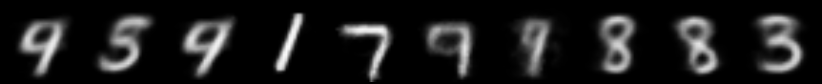

In [21]:
sample_z = z[torch.randint(0, len(z), (10,))] # ランダムに10個選ぶ
sample_z = torch.unsqueeze(sample_z, 0) # バッチ次元を追加
sample_z = sample_z.to(device).float() # GPUに転送 & float32に変換
sample_x = ae.decoder(sample_z) # 画像生成

img = sample_x.view(-1, 1, 28, 28).cpu()
img = transforms.Resize(80)(img)
img = torchvision.utils.make_grid(img, nrow=len(img))
img = transforms.functional.to_pil_image(img)
img

手書き数字が生成できた。

<br>

今回は、先にAEを学習させてから潜在変数の分布を求めたが、先に何らかの分布を定め、潜在変数がその分布に従うように学習することもできる。そのモデルはVAEと呼び、主に生成モデルとして様々な場面で活用されている。これについては別のノートブックでまとめる。